# Summary

This code provides a comprehensive pipeline for simulating the results of the 2022 World Cup. I use two databases one with international results and another with international rankings. The simulation starts from the group stages and progresses to the knockout stages until a winner is determined.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [2]:
warnings.filterwarnings("ignore")

# Data Preparation

In [3]:
# Load Data
df_results = pd.read_csv("results.csv")
df_results["date"] = pd.to_datetime(df_results["date"])


In [4]:
# Basic Cleaning
df_results.dropna(inplace=True)


In [5]:
# Filter Data
df_results = df_results[(df_results["date"] >= "2020-1-1") & (df_results["date"] < "2022-11-1")].reset_index(drop=True)

In [6]:
# Load and process the rankings dataset
rank = pd.read_csv("fifa_ranking-2023-07-20.csv")  # Assuming the name of the ranking dataset file
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2020-1-1") & (rank["rank_date"] < "2022-11-1")].reset_index(drop=True)



Fixing the different names in different datasets

In [7]:
# Fix different names in the two datasets
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

Merging the datasets

In [8]:
# Merge the datasets
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

df_wc_ranked = df_results.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

df = df_wc_ranked


In [9]:
france_games = df[(df['home_team'] == 'France') | (df['away_team'] == 'France')]
last_5_france_games = france_games.tail(5)
display(last_5_france_games)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
1681,2022-06-06,Croatia,France,1,1,UEFA Nations League,Split,Croatia,False,1621.11,1620.74,16.0,1.0,1789.85,1786.15,3.0,0.0
1748,2022-06-10,Austria,France,1,1,UEFA Nations League,Vienna,Austria,False,1500.37,1511.56,34.0,4.0,1789.85,1786.15,3.0,0.0
1803,2022-06-13,France,Croatia,0,1,UEFA Nations League,Paris,France,False,1789.85,1786.15,3.0,0.0,1621.11,1620.74,16.0,1.0
1854,2022-09-22,France,Austria,2,0,UEFA Nations League,Paris,France,False,1764.85,1764.85,4.0,0.0,1502.47,1502.47,33.0,0.0
1911,2022-09-25,Denmark,France,2,0,UEFA Nations League,Copenhagen,Denmark,False,1665.47,1665.47,10.0,0.0,1764.85,1764.85,4.0,0.0


# Feature Engineering

feature that shows what team won and how many points they got

In [10]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [11]:
df[["result", "home_team_points", "away_team_points"]] = results

columns that will help in the creation of the features: ranking difference, points won at the game vs. team faced rank, and goals difference in the game.

In [12]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [13]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [14]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [15]:
team_stats = home_team.append(away_team)

In [16]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2020-09-03,Germany,1,1,15.0,8.0,0.0,1602.00,2,7.0,0.125000,1
1,2020-09-03,Ukraine,2,1,24.0,12.0,0.0,1537.00,0,12.0,0.250000,3
2,2020-09-03,Russia,3,1,38.0,29.0,0.0,1470.00,0,9.0,0.103448,3
3,2020-09-03,Turkey,0,1,29.0,52.0,0.0,1494.00,1,-23.0,0.000000,0
4,2020-09-03,Bulgaria,1,1,59.0,34.0,0.0,1381.00,2,25.0,0.029412,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2022-09-27,Serbia,2,0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
1963,2022-09-27,Slovenia,1,1,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
1964,2022-09-27,Cyprus,1,5,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
1965,2022-09-27,Northern Ireland,1,3,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


Now lets create some predictive features based off intuition 

In [17]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [18]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [19]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [20]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [21]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [22]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [23]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

Check if its a friendly match

In [24]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [25]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

Now the lets see the entire df

In [26]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.head()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
0,2020-09-03,Germany,Spain,15.0,8.0,1,1,2,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,2020-09-03,Ukraine,Switzerland,24.0,12.0,2,1,0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2020-09-03,Russia,Serbia,38.0,29.0,3,1,0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,2020-09-03,Turkey,Hungary,29.0,52.0,0,1,1,-23.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,2020-09-03,Bulgaria,Republic of Ireland,59.0,34.0,1,1,2,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [27]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   91
home_goals_mean_l5                91
home_goals_suf_mean               91
home_goals_suf_mean_l5            91
home_rank_mean                    91
home_rank_mean_l5                 91
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  101
away_goals_mean_l5               101
away_goals_suf_mean              101
away_goals_suf_mean_l5           101
away_rank_mean                   101
away_rank_mean_l5                101
away_points_mean                   0
away_points_mean_l5                0
h

In [28]:
base_df_no_fg = base_df.dropna()

In [29]:
df = base_df_no_fg

# Feature Analysis

In [30]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

In [31]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [32]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

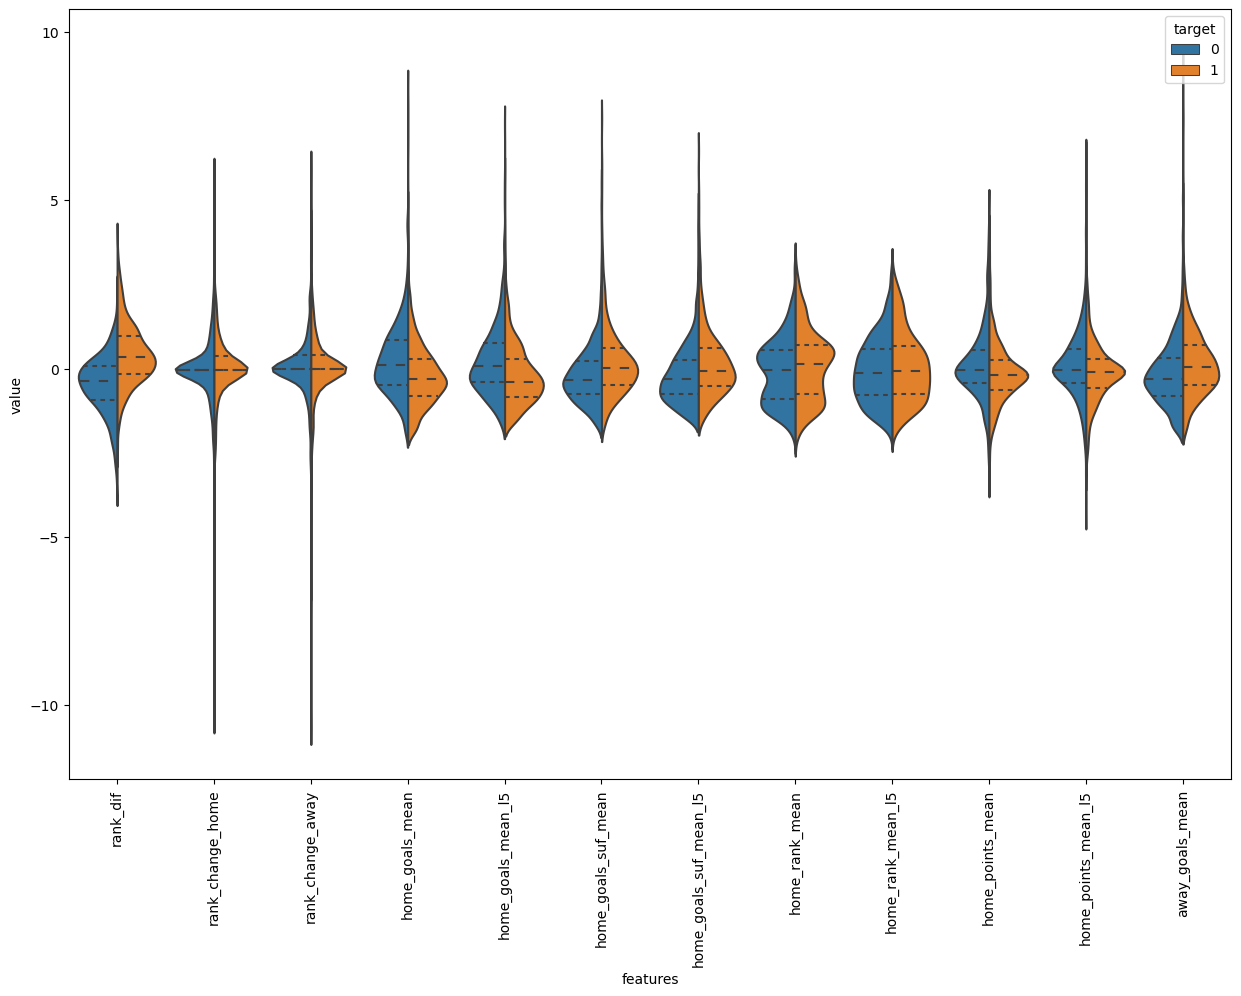

In [33]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

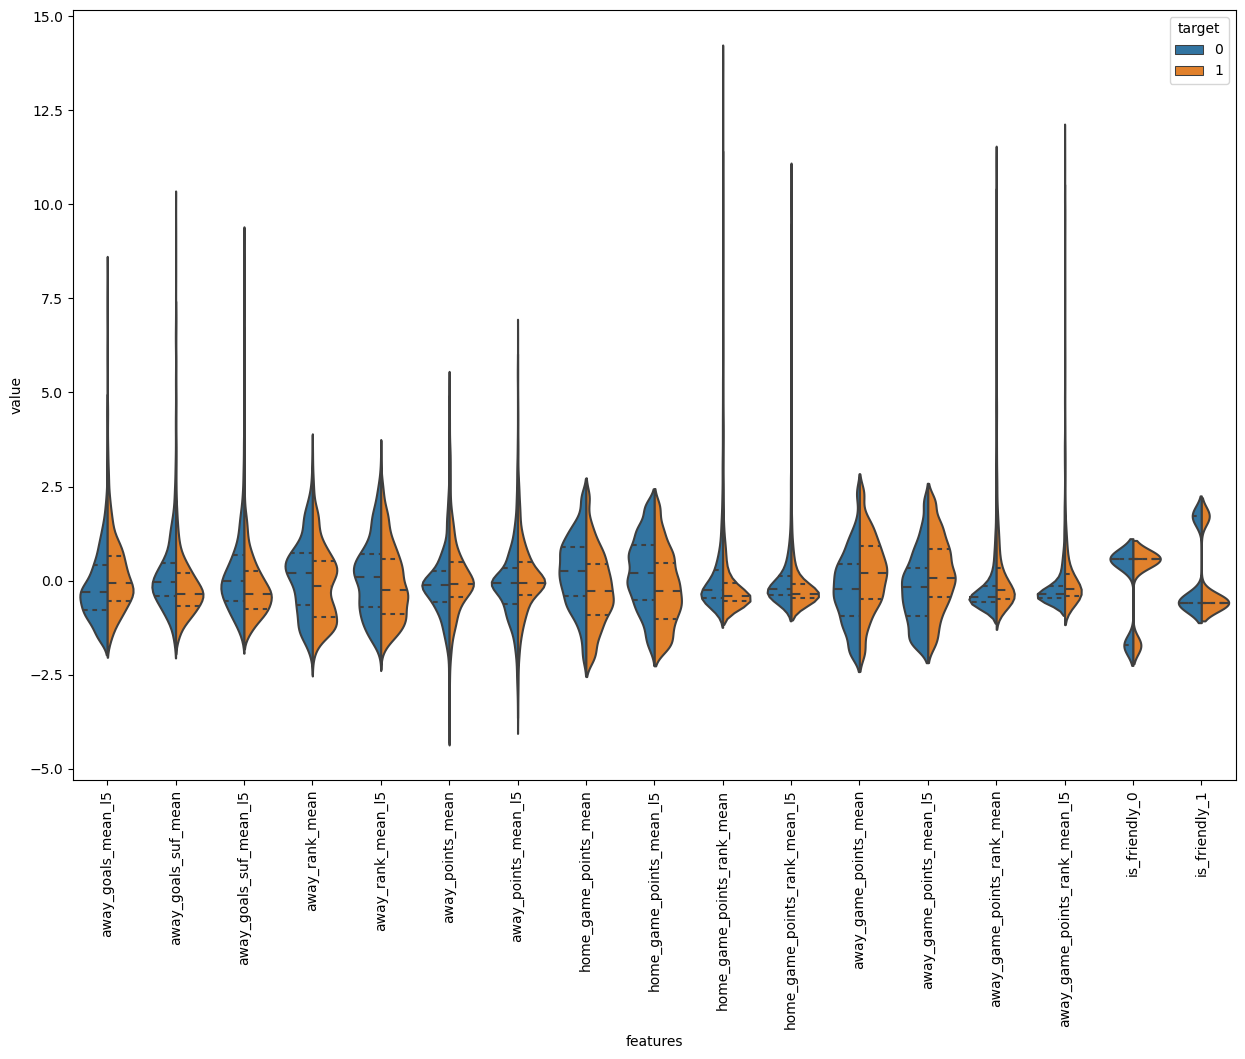

In [34]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

ank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [35]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]


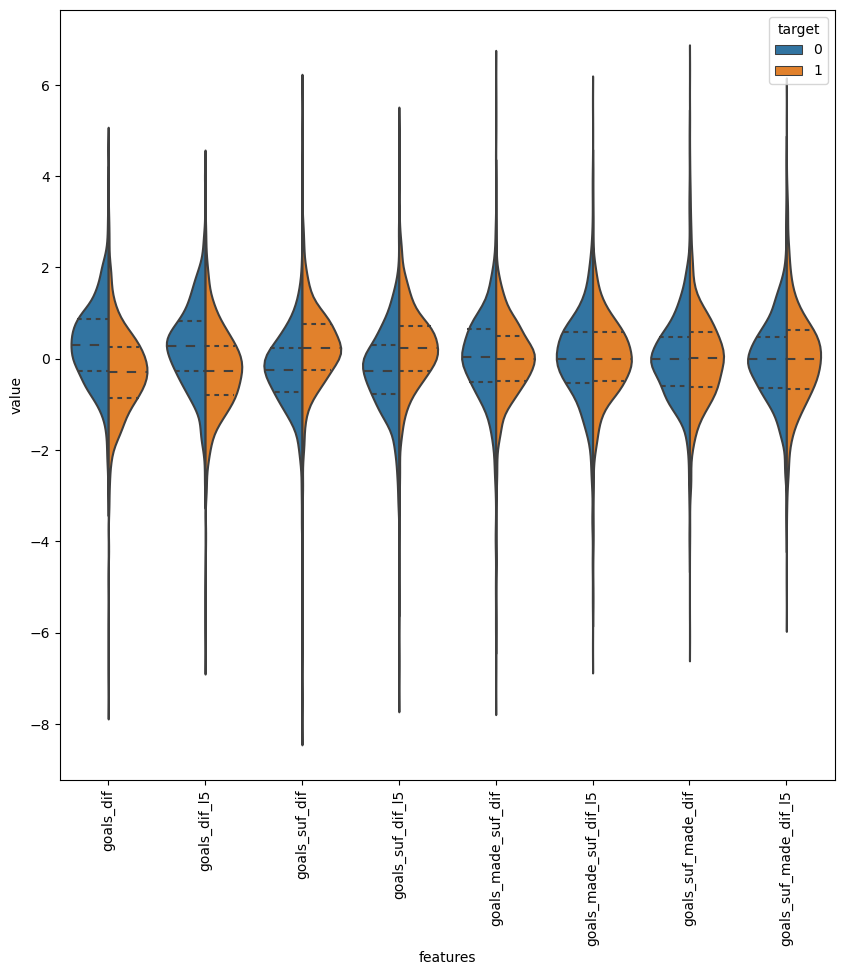

In [36]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

goal differences are good separator, and goals suffered difference too. Differences between goals made and goals suffered of the teams are not very good separators

In [37]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [38]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [39]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

The final features:

In [40]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

# ML Model

In [41]:
model_db = create_db(df)

In [42]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.22, random_state=100)

In [44]:
# Gradient Boosting Model
gb = GradientBoostingClassifier(random_state=100)
params_gb = {
    "learning_rate": [0.01, 0.02, 0.03],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_depth": [3, 5, 10],
    "max_features": ["sqrt"],
    "n_estimators": [100, 200]
}
gb_cv = GridSearchCV(gb, params_gb, cv=3, n_jobs=-1, verbose=False)
gb_cv.fit(X_train.values, np.ravel(y_train))


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [45]:
# Random Forest Model
rf = RandomForestClassifier(random_state=100)
params_rf = {
    "max_depth": [25],
    "min_samples_split": [10],
    "max_leaf_nodes": [175],
    "min_samples_leaf": [5],
    "n_estimators": [250],
    "max_features": ["sqrt"]
}
rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)
rf_cv.fit(X_train.values, np.ravel(y_train))


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [25], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [46]:
gb_best_params = gb_cv.best_params_
rf_best_params = rf_cv.best_params_

In [47]:
gb_best_params, rf_best_params

({'learning_rate': 0.03,
  'max_depth': 3,
  'max_features': 'sqrt',
  'min_samples_leaf': 3,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'max_depth': 25,
  'max_features': 'sqrt',
  'max_leaf_nodes': 175,
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 250})

# Model Analysis

In [48]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")


Analysis for Gradient Boosting Model:


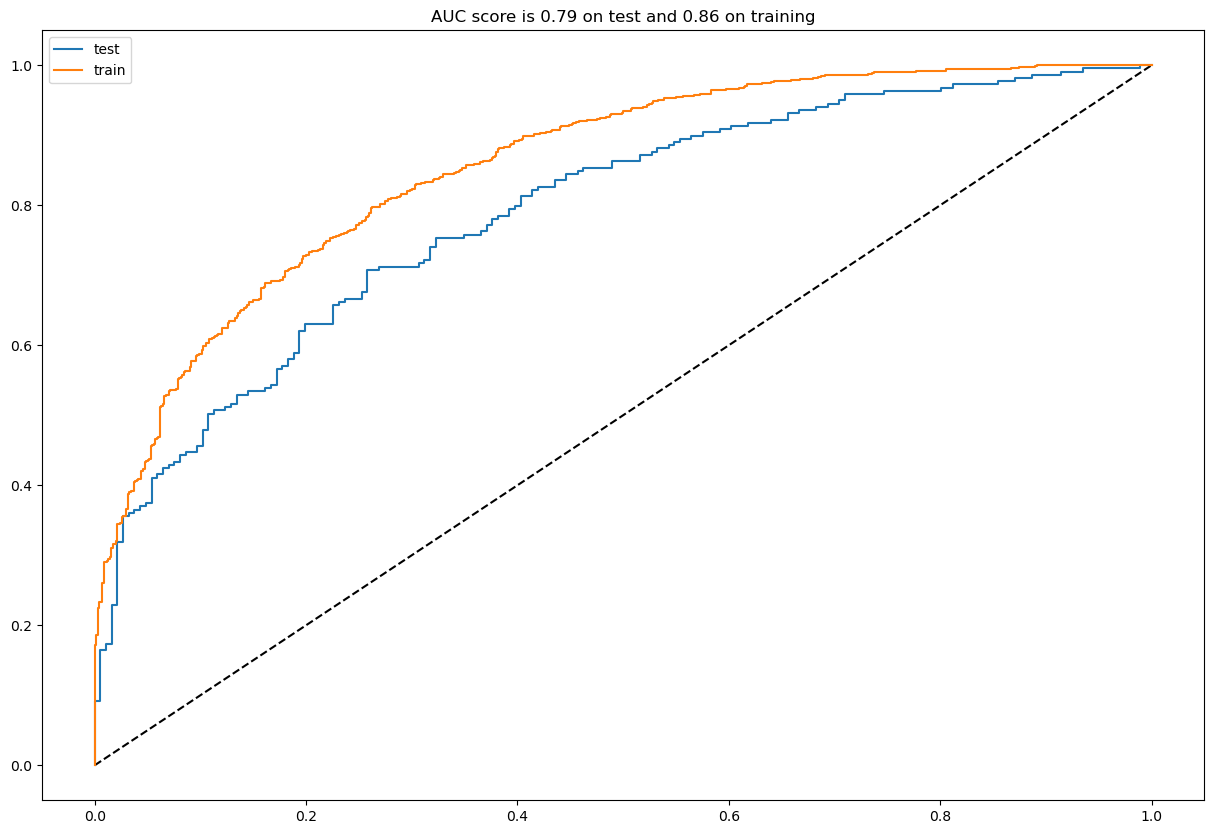

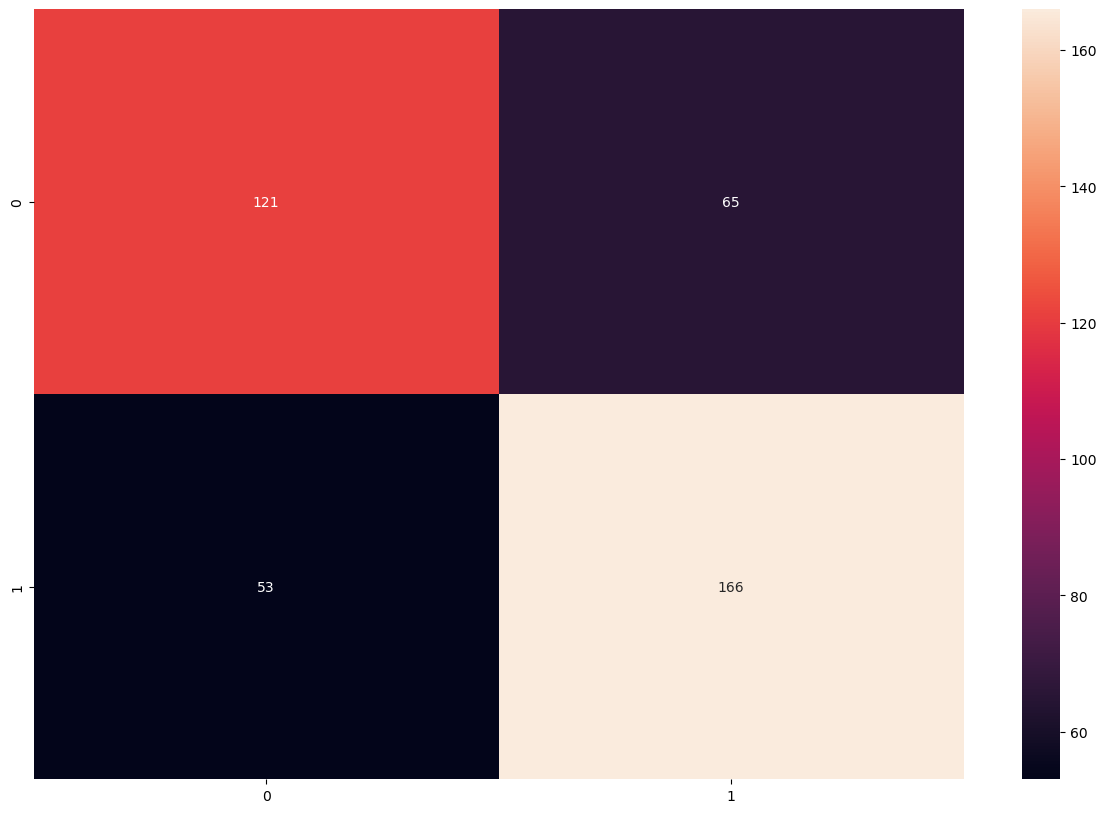

In [49]:
print("Analysis for Gradient Boosting Model:")
analyze(gb_cv.best_estimator_)

Analysis for Random Forest Model:


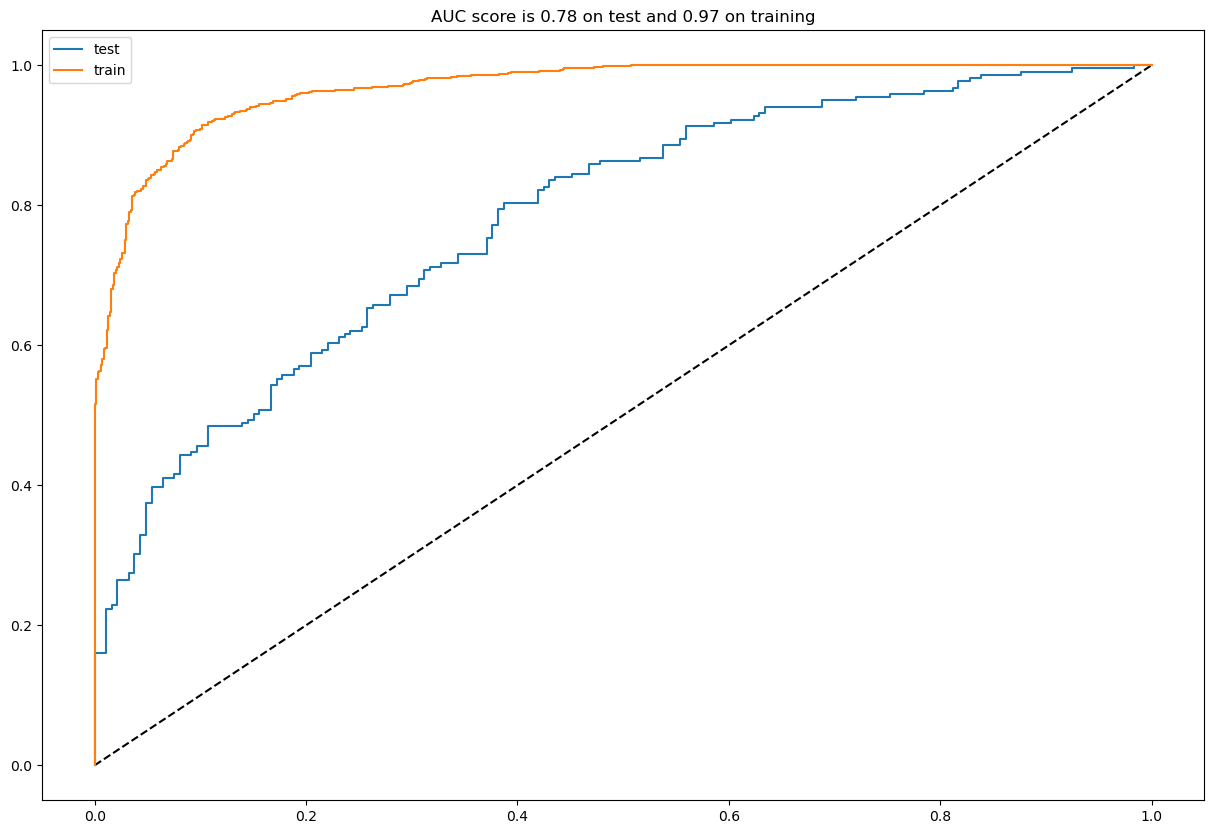

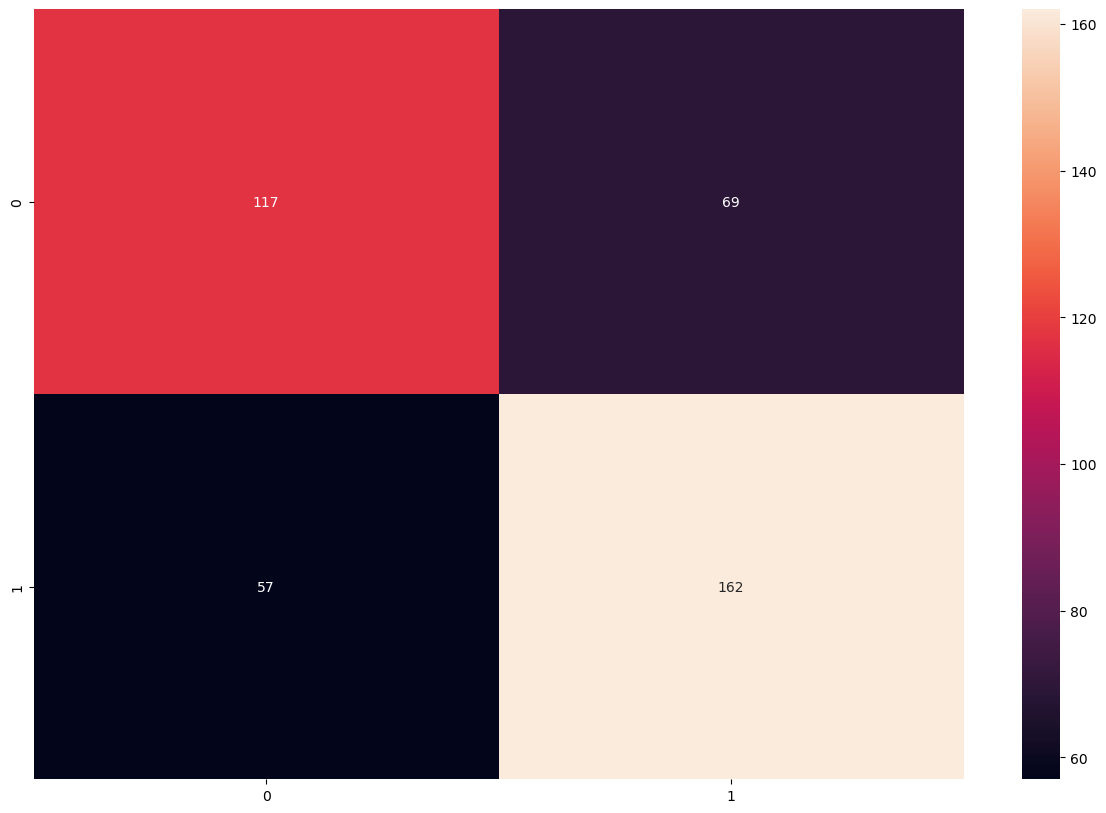

In [50]:
print("Analysis for Random Forest Model:")
analyze(rf_cv.best_estimator_)

It seems the random foresting model seems to be a bit to overfit so we will use gradient boosting for the model in the simulation

# Group Stage Simulation 

In [51]:
# Define the groups
groups = {
    'Group A': ['Netherlands', 'Senegal', 'Ecuador', 'Qatar'],
    'Group B': ['England', 'United States', 'Iran', 'Wales'],
    'Group C': ['Argentina', 'Mexico', 'Poland', 'Saudi Arabia'],
    'Group D': ['France', 'Denmark', 'Tunisia', 'Australia'],
    'Group E': ['Spain', 'Germany', 'Japan', 'Costa Rica'],
    'Group F': ['Belgium', 'Croatia', 'Morocco', 'Canada'],
    'Group G': ['Brazil', 'Switzerland', 'Serbia', 'Cameroon'],
    'Group H': ['Portugal', 'Uruguay', 'South Korea', 'Ghana']
}

# Initialize the table with teams, points, and win probabilities
table = {}
for group, team_list in groups.items():
    table[group] = [[team, 0, []] for team in team_list]

# Generate the matches for each group
matches = []
for group, teams in groups.items():
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            matches.append((group, teams[i], teams[j]))

print("Table:", table)
print("Matches:", matches)


Table: {'Group A': [['Netherlands', 0, []], ['Senegal', 0, []], ['Ecuador', 0, []], ['Qatar', 0, []]], 'Group B': [['England', 0, []], ['United States', 0, []], ['Iran', 0, []], ['Wales', 0, []]], 'Group C': [['Argentina', 0, []], ['Mexico', 0, []], ['Poland', 0, []], ['Saudi Arabia', 0, []]], 'Group D': [['France', 0, []], ['Denmark', 0, []], ['Tunisia', 0, []], ['Australia', 0, []]], 'Group E': [['Spain', 0, []], ['Germany', 0, []], ['Japan', 0, []], ['Costa Rica', 0, []]], 'Group F': [['Belgium', 0, []], ['Croatia', 0, []], ['Morocco', 0, []], ['Canada', 0, []]], 'Group G': [['Brazil', 0, []], ['Switzerland', 0, []], ['Serbia', 0, []], ['Cameroon', 0, []]], 'Group H': [['Portugal', 0, []], ['Uruguay', 0, []], ['South Korea', 0, []], ['Ghana', 0, []]]}
Matches: [('Group A', 'Netherlands', 'Senegal'), ('Group A', 'Netherlands', 'Ecuador'), ('Group A', 'Netherlands', 'Qatar'), ('Group A', 'Senegal', 'Ecuador'), ('Group A', 'Senegal', 'Qatar'), ('Group A', 'Ecuador', 'Qatar'), ('Group B

In [52]:
def find_stats(team_1):
#team_1 = "Qatar"
    last_game = base_df[(base_df["home_team"] == team_1) | (base_df["away_team"] == team_1)].tail(1)

    if last_game["home_team"].values[0] == team_1:
        team_1_rank = last_game["rank_home"].values[0]
        team_1_goals = last_game["home_goals_mean"].values[0]
        team_1_goals_l5 = last_game["home_goals_mean_l5"].values[0]
        team_1_goals_suf = last_game["home_goals_suf_mean"].values[0]
        team_1_goals_suf_l5 = last_game["home_goals_suf_mean_l5"].values[0]
        team_1_rank_suf = last_game["home_rank_mean"].values[0]
        team_1_rank_suf_l5 = last_game["home_rank_mean_l5"].values[0]
        team_1_gp_rank = last_game["home_game_points_rank_mean"].values[0]
        team_1_gp_rank_l5 = last_game["home_game_points_rank_mean_l5"].values[0]
    else:
        team_1_rank = last_game["rank_away"].values[0]
        team_1_goals = last_game["away_goals_mean"].values[0]
        team_1_goals_l5 = last_game["away_goals_mean_l5"].values[0]
        team_1_goals_suf = last_game["away_goals_suf_mean"].values[0]
        team_1_goals_suf_l5 = last_game["away_goals_suf_mean_l5"].values[0]
        team_1_rank_suf = last_game["away_rank_mean"].values[0]
        team_1_rank_suf_l5 = last_game["away_rank_mean_l5"].values[0]
        team_1_gp_rank = last_game["away_game_points_rank_mean"].values[0]
        team_1_gp_rank_l5 = last_game["away_game_points_rank_mean_l5"].values[0]
    
    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]


In [53]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [54]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb_cv.best_estimator_.predict_proba([features_g1])
    probs_g2 = gb_cv.best_estimator_.predict_proba([features_g2])
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]
print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]:
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group Group A ----------
Group Group A - Netherlands vs. Senegal: Draw
Group Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.78 probability
Group Group A - Netherlands vs. Qatar: Winner Netherlands with 0.75 probability
Group Group A - Senegal vs. Ecuador: Draw
Group Group A - Senegal vs. Qatar: Draw
Group Group A - Ecuador vs. Qatar: Winner Ecuador with 0.67 probability


Group Group A advanced: 
Netherlands -------- 7
Ecuador -------- 4
Senegal -------- 3
Qatar -------- 1


---------- Starting Analysis for Group Group B ----------
Group Group B - England vs. United States: Draw
Group Group B - England vs. Iran: Draw
Group Group B - England vs. Wales: Winner England with 0.66 probability
Group Group B - United States vs. Iran: Draw
Group Group B - United States vs. Wales: Winner United States with 0.60 probability
Group Group B - Iran vs. Wales: Winner Iran with 0.54 probability


Group Group B advanced: 
England -------- 5
United States

# Knockout Stage

In [55]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [56]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])
        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb_cv.best_estimator_.predict_proba([features_g1])
            probs_g2 = gb_cv.best_estimator_.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb_cv.best_estimator_.predict_proba([features_g1])
            probs_g2 = gb_cv.best_estimator_.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: United States advances with prob 0.60
Argentina vs. France: Argentina advances with prob 0.55
Spain vs. Morocco: Spain advances with prob 0.67
Brazil vs. Uruguay: Brazil advances with prob 0.64
Ecuador vs. England: England advances with prob 0.62
Mexico vs. Denmark: Denmark advances with prob 0.57
Germany vs. Belgium: Germany advances with prob 0.50
Serbia vs. Portugal: Portugal advances with prob 0.69
----------
Starting simulation of Quarter-Final
----------


United States vs. Argentina: Argentina advances with prob 0.62
Spain vs. Brazil: Brazil advances with prob 0.63
England vs. Denmark: Denmark advances with prob 0.52
Germany vs. Portugal: Portugal advances with prob 0.57
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.52
Denmark vs. Portugal: Portugal advances with prob 0.55
----------
Starting simulation of Final
----------


A

Of course this simulation and model does not not account for players, injuries and many of the other facts that come in to play in a match but it did correctly simulate Argentina winning. But there were many interesing upsets like Denmark making a very strong run throughout the world cup.

In the end this was a project for me to learn more about the machine learning pipeline and applying it to something i am passionate about which is football/soccer.